# Import

In [2]:
import yaml
import pandas as pd
import anndata as ad 
import numpy as np
import scanpy as sc 
from src.exp_analysis.helper import plot_cumulative_density
def extract_data(data, reg='reg1', dataset_id='scgen_pearson'):
    i = 0
    for entry in data:
        if entry['dataset_id']!=dataset_id:
            continue
        try:
            rg, method_id = entry['method_id'].split('-')
        except:
            rg, method_id, _ = entry['method_id'].split('-')
        if rg != reg:
            continue
        dataset_id = entry['dataset_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        
        df = pd.DataFrame([metric_values], index=[method_id], columns=metric_ids)
        if i==0:
            df_reg = df
        else:
            df_reg = pd.concat([df_reg, df], axis=0)
        i+=1
    return df_reg
def process_data(RUN_ID, models_all):
    !aws s3 sync s3://openproblems-data/resources/grn/results/{RUN_ID} resources/results/{RUN_ID} 
    base_folder = f'resources/results/{RUN_ID}'
    result_file = f'{base_folder}/scores.yaml'
        

    with open(result_file, 'r') as file:
        data = yaml.safe_load(file)
    if True:
        df_reg1 = extract_data(data, reg='reg1').reindex(models_all).drop(columns=['Mean'])
        df_reg2 = extract_data(data, reg='reg2').reindex(models_all).drop(columns=['Mean'])
    else:
        df_reg1 = extract_data(data, reg='reg1').drop(columns=['Mean'])
        df_reg2 = extract_data(data, reg='reg2').drop(columns=['Mean'])
    df_all = pd.concat([df_reg1, df_reg2], axis=1).fillna(0)
    return df_all

# Add to process data pipeline

In [85]:
# process multiomics
# !pip install --user scikit-misc
from sklearn.preprocessing import StandardScaler 
adata = ad.read_h5ad('resources/grn-benchmark/multiomics_rna.h5ad')
def antoine_filtering(adata):
    threshold = 0.1
    mask = adata.X!=0
    mask_obs = (np.sum(mask, axis=1).A.flatten()/mask.shape[1])>threshold
    mask_var = (np.sum(mask, axis=0).A.flatten()/mask.shape[0])>threshold
    adata.obs['high_coverage'] = mask_obs
    adata.var['high_coverage'] = mask_var
antoine_filtering(adata)

# raw hvgs
var = sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=7000, inplace=False)
adata.var['hvg_counts'] = var.highly_variable


In [5]:
# subset to donor 0
adata = ad.read_h5ad('resources/grn-benchmark/multiomics_rna.h5ad')
adata[adata.obs.donor_id=='donor_0', :].write('resources/grn-benchmark/multiomics_rna_0.h5ad')

# Marco data 

In [16]:
!ls resources_local/mccalla_extended/

__MACOSX				 shalek.h5ad
han.h5ad				 shalek_KDunion.csv
han_KDunion.csv				 shalek_chipunion.csv
han_chipunion.csv			 shalek_chipunion_KDUnion_intersect.csv
han_chipunion_KDUnion_intersect.csv	 zhao.h5ad
jackson.h5ad				 zhao_KDunion.csv
jackson_KDunion.csv			 zhao_chipunion.csv
jackson_chipunion.csv			 zhao_chipunion_KDUnion_intersect.csv
jackson_chipunion_KDUnion_intersect.csv


In [13]:
import subprocess
import anndata as ad 
import pandas as pd
import numpy as np
for cell_type in ['zhao', 'shalek', 'han', 'jackson']:
    adata = ad.read_h5ad(f'resources_local/mccalla_extended/{cell_type}.h5ad')
    adata.layers['norm'] = adata.X
    adata.obs['cell_type'] = 'onecelltype'
    adata.write(f'resources_local/mccalla_extended/{cell_type}.h5ad')
    subsample = min([10000, len(adata)])
    for GT in ['KDunion', 'chipunion', 'chipunion_KDUnion_intersect']:
        GT_df = pd.read_csv(f'resources_local/mccalla_extended/{cell_type}_{GT}.csv')
        gene_overlap = np.intersect1d(adata.var_names, GT_df.target.unique()).shape
        print(f"{cell_type}-{GT}. adata shape: {adata.shape}, GT size: {GT_df.shape}, Gene overlap: {gene_overlap}")
        command = f"viash run src/metrics/regression_1/config.vsh.yaml -- --perturbation_data resources_local/mccalla_extended/{cell_type}.h5ad --prediction resources_local/mccalla_extended/{cell_type}_{GT}.csv --layer norm --subsample {subsample} --apply_tf false --tf_all resources/prior/tf_all.csv --max_n_links -1 --verbose 1 --score output/{cell_type}_{GT}.h5ad"
        subprocess.run(command, shell=True, check=True)

zhao-KDunion. adata shape: (36199, 8442), GT size: (105136, 3), Gene overlap: (8425,)
/viash_automount/tmp/viash-run-regression_1-8RZIHd.py:56: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  output = ad.AnnData(
   ex(False)_tf(-1)  ex(True)_tf(-1)      Mean
0         -0.020129          0.03817  0.009021
(3,) (3,)
zhao-chipunion. adata shape: (36199, 8442), GT size: (60662, 3), Gene overlap: (8378,)
/viash_automount/tmp/viash-run-regression_1-rLuWXt.py:56: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  output = ad.AnnData(
   ex(False)_tf(-1)  ex(True)_tf(-1)      Mean
0         -0.006

# Test analysis

### Baseline scores on donor 0. Normalized, non cell type specific

In [7]:
# RUN_ID="donor_0_normalized_noncelltype"  
# models_all = ['pearson_corr', 'pearson_causal',  'positive_control']
# df_all = process_data(RUN_ID, models_all)
# df_all.style.background_gradient()

### Baseline scores on donor 0. Not normalized, non cell type specific

In [6]:
# RUN_ID="donor_0_notnormalized_noncelltype"
# models_all = ['pearson_corr', 'pearson_causal',  'positive_control']
# df_all = process_data(RUN_ID, models_all)
# df_all.style.background_gradient()

### Baseline scores on donor 0. notnormalized, cell type specific

In [5]:
# RUN_ID="donor_0_notnormalized_celltype"
# models_all = ['pearson_corr', 'pearson_causal',  'positive_control']
# df_all = process_data(RUN_ID, models_all)
# df_all.style.background_gradient()

### Baseline scores on donor 0. Normalized, non cell type specific, hvgs

In [8]:
RUN_ID="donor_0_normalized_noncelltype_hvg"  
models_all = ['pearson_corr', 'pearson_causal',  'positive_control']
df_all = process_data(RUN_ID, models_all)
df_all.style.background_gradient()

download: s3://openproblems-data/resources/grn/results/donor_0_normalized_noncelltype_hvg/state.yaml to resources/results/donor_0_normalized_noncelltype_hvg/state.yaml
download: s3://openproblems-data/resources/grn/results/donor_0_normalized_noncelltype_hvg/trace.txt to resources/results/donor_0_normalized_noncelltype_hvg/trace.txt
download: s3://openproblems-data/resources/grn/results/donor_0_normalized_noncelltype_hvg/scores.yaml to resources/results/donor_0_normalized_noncelltype_hvg/scores.yaml
download: s3://openproblems-data/resources/grn/results/donor_0_normalized_noncelltype_hvg/ridge.pearson_causal.pearson_causal.prediction.csv to resources/results/donor_0_normalized_noncelltype_hvg/ridge.pearson_causal.pearson_causal.prediction.csv
download: s3://openproblems-data/resources/grn/results/donor_0_normalized_noncelltype_hvg/ridge.pearson_corr.pearson_corr.prediction.csv to resources/results/donor_0_normalized_noncelltype_hvg/ridge.pearson_corr.pearson_corr.prediction.csv
download

,ex(False)_tf(-1),ex(True)_tf(-1),static-theta-0.0,static-theta-0.5
pearson_corr,0.239620,0.518217,0.529502,0.524232
pearson_causal,0.364656,0.592457,0.741328,0.560490
positive_control,0.492563,0.681568,0.655407,0.574608


# Commands

In [1]:
!aws s3 sync resources/grn-benchmark s3://openproblems-data/resources/grn/grn-benchmark --delete

delete: s3://openproblems-data/resources/grn/grn-benchmark/multiomics_rna_qc.h5ad
delete: s3://openproblems-data/resources/grn/grn-benchmark/multiomics_rna_qc_bc.h5ad


In [1]:
!aws s3 sync  s3://openproblems-data/resources/grn/grn-benchmark resources/grn-benchmark --delete

delete: resources/grn-benchmark/multiomics_rna_qc.h5ad
download: s3://openproblems-data/resources/grn/grn-benchmark/multiomics_rna.h5ad to resources/grn-benchmark/multiomics_rna.h5ad
download: s3://openproblems-data/resources/grn/grn-benchmark/multiomics_rna_0.h5ad to resources/grn-benchmark/multiomics_rna_0.h5ad


# Metacell

In [ ]:
if par['metacell']:
    print('metacell')
    def create_meta_cells(df, n_cells=15):
        meta_x = []
        for i in range(0, df.shape[0], n_cells):
            meta_x.append(df.iloc[i:i+n_cells, :].sum(axis=0).values)
        df = pd.DataFrame(meta_x, columns=df.columns)
        return df
            
    adata_df = pd.DataFrame(multiomics_rna.X.todense(), columns=multiomics_rna.var_names)
    adata_df['cell_type'] = multiomics_rna.obs['cell_type'].values
    adata_df['donor_id'] = multiomics_rna.obs['donor_id'].values
    df = adata_df.groupby(['cell_type','donor_id']).apply(lambda df: create_meta_cells(df))
    X = df.values
    var = pd.DataFrame(index=df.columns)
    obs = df.reset_index()[['cell_type','donor_id']]
    multiomics_rna = ad.AnnData(X=X, obs=obs, var=var)

# Robustness analysis

In [1]:
# !viash ns build --setup cb --parallel
!viash ns build --setup cb -q run_robustness_analysis


temporaryFolder: /tmp/viash_hub_repo10268443552668753296 uri: https://github.com/openproblems-bio/openproblems-v2.git
Cloning into '.'...
checkout out: List(git, checkout, origin/main_build, --, .) 0 
Exporting run_robustness_analysis (workflows) =nextflow=> /mnt/c/Users/nourisa/Documents/testProjs/ongoing/task_grn_inference/target/nextflow/workflows/run_robustness_analysis
Not all configs built successfully
  39 configs were disabled
  1/1 configs built successfully


## Shuffle net

In [3]:
!bash scripts/run_robust_analys.sh "net"

In [7]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_net ./resources/results/robust_analy_reg2_net

download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/state.yaml to resources/results/robust_analy_reg2_net/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/scores.yaml to resources/results/robust_analy_reg2_net/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/metric_configs.yaml to resources/results/robust_analy_reg2_net/metric_configs.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_net/trace.txt to resources/results/robust_analy_reg2_net/trace.txt


## Add noise to weights

In [41]:
!bash scripts/run_robust_analys.sh "weight"

weight
Nextflow 24.04.4 is available - Please consider updating your version to it
N E X T F L O W  ~  version 23.10.4
Launching `target/nextflow/workflows/run_robustness_analysis/main.nf` [dreamy_davinci] DSL2 - revision: 6bd5cda1f4
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -

[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (1)
[5f/aa4675] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (6)
[f3/689356] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustn

In [9]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight ./resources/results/robust_analy_reg2_weight

download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/scores.yaml to resources/results/robust_analy_reg2_weight/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/state.yaml to resources/results/robust_analy_reg2_weight/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/metric_configs.yaml to resources/results/robust_analy_reg2_weight/metric_configs.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_weight/trace.txt to resources/results/robust_analy_reg2_weight/trace.txt


## Negative vs positive controls

In [8]:
!bash scripts/run_pc_vs_nc.sh "pc_vs_nc"

In [12]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_pc_vs_nc ./resources/results/robust_analy_reg2_pc_vs_nc

## regulatory sign

In [50]:
!bash scripts/run_robust_analys.sh "sign"

sign
Nextflow 24.04.4 is available - Please consider updating your version to it
N E X T F L O W  ~  version 23.10.4
Launching `target/nextflow/workflows/run_robustness_analysis/main.nf` [soggy_sinoussi] DSL2 - revision: d55e1b9116
[-        ] process > run_robustness_analysis:run... -

[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -

[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (2)
[2f/3f5479] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:run... -
[-        ] process > run_robustness_analysis:pub... -

executor >  local (6)
[f9/652d7d] process > run_robustness_analysis:run... [  0%] 0 of 30
[-        ] process > run_robustne

In [10]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign ./resources/results/robust_analy_reg2_sign

download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/trace.txt to resources/results/robust_analy_reg2_sign/trace.txt
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/state.yaml to resources/results/robust_analy_reg2_sign/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/scores.yaml to resources/results/robust_analy_reg2_sign/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_reg2_sign/metric_configs.yaml to resources/results/robust_analy_reg2_sign/metric_configs.yaml


## Corr vs causal

In [ ]:
!bash scripts/run_robust_analys_causal.sh 

In [4]:
!aws s3 sync s3://openproblems-data/resources/grn/results/robust_analy_causal_1 ./resources/results/robust_analy_causal_1

download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/scores.yaml to resources/results/robust_analy_causal_1/scores.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/state.yaml to resources/results/robust_analy_causal_1/state.yaml
download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/trace.txt to resources/results/robust_analy_causal_1/trace.txt
download: s3://openproblems-data/resources/grn/results/robust_analy_causal_1/metric_configs.yaml to resources/results/robust_analy_causal_1/metric_configs.yaml


In [13]:
!viash run src/robustness_analysis/causal/config.vsh.yaml -- --causal true 
!viash run src/metrics/regression_1/config.vsh.yaml -- --prediction output/prediction.csv

Read data

Noramlize data
Create corr net
Processing groups: 100%|██████████| 4/4 [00:41<00:00, 10.47s/it]
Output GRN


In [56]:
# 
corr_scores = []
for i in range(1, n_iter):    
    corr_scores.append(ad.read_h5ad(f"output/causal/scores/net_corr_{i}.h5ad").uns['metric_values'][0])
pc_score = ad.read_h5ad(f"output/causal/scores/net_pc.h5ad").uns['metric_values'][0]

In [59]:
(corr_scores<pc_score).sum()

95

# GRN Evaluation

In [3]:
# !aws s3 sync resources/grn_models/ s3://openproblems-data/resources/grn/grn_models
tag = "default_donor_0_subset"
reg_type='ridge'
run_id=f'{tag}_{reg_type}'

In [ ]:
!bash scripts/run_grn_evaluation.sh {tag} {reg_type}

In [4]:

!aws s3 sync s3://openproblems-data/resources/grn/results/{run_id} resources/results/{run_id}

base_folder = f'resources/results/{run_id}'
models_all = ['negative_control', 'pearson', 
              'pearson_causal',  'positive_control', 'collectri','granie', 'figr', 'celloracle', 
              'scglue', 'scenicplus', 'portia','ppcor', 'grnboost2', 'genie3']

def extract_data(data, reg='reg1', dataset_id='scgen_pearson'):
    i = 0
    for entry in data:
        if entry['dataset_id']!=dataset_id:
            continue
        try:
            rg, method_id = entry['method_id'].split('-')
        except:
            rg, method_id, _ = entry['method_id'].split('-')
        if rg != reg:
            continue
        dataset_id = entry['dataset_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        
        df = pd.DataFrame([metric_values], index=[method_id], columns=metric_ids)
        if i==0:
            df_reg = df
        else:
            df_reg = pd.concat([df_reg, df], axis=0)
        i+=1
    return df_reg
import yaml
import pandas as pd


result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)
if True:
    df_reg1 = extract_data(data, reg='reg1').reindex(models_all).drop(columns=['Mean'])
    df_reg2 = extract_data(data, reg='reg2').reindex(models_all).drop(columns=['Mean'])
else:
    df_reg1 = extract_data(data, reg='reg1').drop(columns=['Mean'])
    df_reg2 = extract_data(data, reg='reg2').drop(columns=['Mean'])
df_all = pd.concat([df_reg1, df_reg2], axis=1).fillna(0)
df_all[df_all<0]=0
df_all_n = (df_all-df_all.min(axis=0))/(df_all.max(axis=0)-df_all.min(axis=0))
df_all['Rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_all.style.background_gradient()

,ex(False)_tf(-1),ex(True)_tf(-1),static-theta-0.0,static-theta-0.5,Rank
negative_control,0.000000,0.000000,0.000000,0.000000,9
pearson,0.000000,0.000000,0.000000,0.000000,9
pearson_causal,0.364656,0.592457,0.741328,0.560490,2
positive_control,0.492563,0.681568,0.655407,0.574608,1
collectri,0.000000,0.000000,0.000000,0.000000,9
granie,0.000000,0.000000,0.000000,0.000000,9
figr,0.000000,0.000000,0.000000,0.000000,9
celloracle,0.000000,0.000000,0.000000,0.000000,9
scglue,0.000000,0.000000,0.000000,0.000000,9
scenicplus,0.000000,0.000000,0.000000,0.000000,9


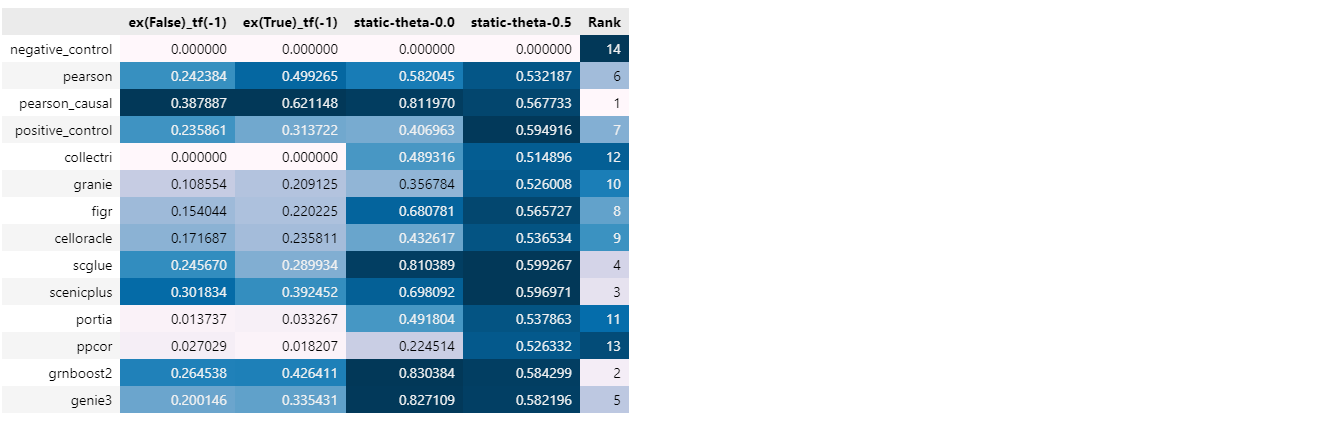